## Hidden Markov Models: forward, Viterbi & Baum-Walch algorithms


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random as random
import pandas as pd
random.seed(42)

### Question 1 : simulation d’un HMM


In [5]:
def SimuHMMdisc(n, param):

    nu = np.array(param['pi'])
   
    B= np.array(param['B'])
    A= np.array(param['A']) 

    z = np.zeros(n, dtype=int)
    x = np.zeros(n, dtype=int)
    
    #sample first hidden state and first observation
    z[0] = np.random.choice(len(nu), p = nu) 
    print(z)
    x[0] = np.random.choice(len(B[z[0]]), p=B[z[0]])
    print(x)
 
    for i in range(1,n):
        z[i]= np.random.choice( len(nu), p=A[z[i-1]])
        print(z)
        x[i] = np.random.choice(len(B[z[i]]), p= B[z[i]])
        print(x)

  
    sequence = list(zip(x, z))
    
    return sequence 


In [6]:
n = int(10)

In [7]:
# Transition Matrix A for the hidden states
A = np.array([
    [0.95, 0.05],
    [0.10, 0.90]
])

# Emission Matrix B
# Rows correspond to hidden states, columns to observable outcomes
# B = np.transpose(np.array([
#     [1/6]*6 + [1/10]*5 + [0.5],
#     [1/6]*6 + [1/10]*5 + [0.5]
# ])).reshape(6, 2)
B = np.array([
    [1/6, 1/6, 1/6, 1/6, 1/6, 1/6],  # Uniform distribution over 6 outcomes for state 0
    [1/10, 1/10, 1/10, 1/10, 1/10, 0.5]  # Different distribution for state 1
])

eigenvalues, eigenvectors = np.linalg.eig(A.T)
pi_vector = eigenvectors[:, np.isclose(eigenvalues, 1)]
pi_real = np.real(pi_vector)
pi = pi_real / np.sum(pi_real)

params = {
    'A': A,
    'B': B,
    'pi': pi.flatten()  
}
params


{'A': array([[0.95, 0.05],
        [0.1 , 0.9 ]]),
 'B': array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
         0.16666667],
        [0.1       , 0.1       , 0.1       , 0.1       , 0.1       ,
         0.5       ]]),
 'pi': array([0.66666667, 0.33333333])}

In [8]:
seq = SimuHMMdisc(n, params)
seq

[0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[1 5 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[1 5 1 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0]
[1 5 1 0 0 0 0 0 0 0]
[0 0 0 1 1 0 0 0 0 0]
[1 5 1 0 5 0 0 0 0 0]
[0 0 0 1 1 0 0 0 0 0]
[1 5 1 0 5 1 0 0 0 0]
[0 0 0 1 1 0 0 0 0 0]
[1 5 1 0 5 1 3 0 0 0]
[0 0 0 1 1 0 0 0 0 0]
[1 5 1 0 5 1 3 1 0 0]
[0 0 0 1 1 0 0 0 0 0]
[1 5 1 0 5 1 3 1 5 0]
[0 0 0 1 1 0 0 0 0 1]
[1 5 1 0 5 1 3 1 5 2]


[(1, 0),
 (5, 0),
 (1, 0),
 (0, 1),
 (5, 1),
 (1, 0),
 (3, 0),
 (1, 0),
 (5, 0),
 (2, 1)]

range(0, 10)


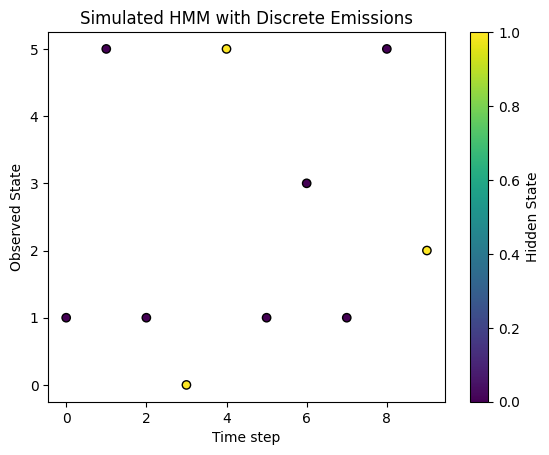

In [9]:
x, z = zip(*seq)
x, z = list(x), list(z)
plt.scatter(range(n), x, c=z, cmap='viridis', edgecolors='k')
print(range(n))
plt.colorbar(label='Hidden State')
plt.xlabel('Time step')
plt.ylabel('Observed State')
plt.title('Simulated HMM with Discrete Emissions')
plt.show()

### Question 2. calcul de la vraisemblance - l’algorithme forward


In [10]:
print(math.exp(-100001))

#avoid overflowing part
def log_sum_exp(x):
    x_max = np.max(x)
    return x_max + np.log(np.sum(np.exp(x - x_max)))

log_sum_exp([-100000, -100001, -100002])

0.0


-99999.59239403556

In [11]:
# K = 4
# nexp = 100  
# mus = np.linspace(0, -1000, nexp) 
# res = pd.DataFrame({
#     'mu': mus,
#     'naive': np.nan,
#     'log_trick': np.nan
# })

# for i in range(len(mus)):
#     a = np.random.normal(loc=mus[i], scale=20, size=K)
#     res.loc[i, 'naive'] = np.log(np.sum(np.exp(a)))
#     res.loc[i, 'log_trick'] = log_sum_exp(a)

# df = res.melt(id_vars='mu', var_name='Method', value_name='logsumexp')


# sns.set(style="whitegrid")
# plt.figure(figsize=(10, 6))
# ax = sns.scatterplot(data=df, x='mu', y='logsumexp', hue='Method', style='Method', s=100, alpha=0.7)
# plt.plot([mus.min(), mus.max()], [mus.min(), mus.max()], 'k--')  # y=x line
# plt.title('Illustration of the log-sum-exp trick')
# plt.show()



$$ \alpha_i(k) = P(observe \, sequence \, up \, until\,  time \, i \, and \, have \, hidden \, state \, at \, k)   $$ 
$$
\log(\alpha_i(k)) = \log \left( \sum_{l=1}^K \alpha_{i-1}(l) \cdot A_{lk} \cdot \Psi_i(k) \right)
$$
$$
\log(\alpha_i(k)) = \log \left( \sum_{l=1}^K e^{\log(\alpha_{i-1}(l) \cdot A_{lk})} \cdot e^{\log(\Psi_i(k))} \right)
$$
$$
\log(\alpha_i(k)) = \log \left( \sum_{l=1}^K e^{\log(\alpha_{i-1}(l)) + \log(A_{lk})} \cdot e^{\log(\Psi_i(k))} \right)
$$
$$
\log(\alpha_i(k)) = \log(\Psi_i(k)) + \log \left( \sum_{l=1}^K e^{\log(\alpha_{i-1}(l)) + \log(A_{lk})} \right)
$$

$$ init: \, \alpha_1(l) = p(x_1, z_1 = l) = \nu_l \Psi_1(l), \, \forall l$$

In [12]:
def forward(x, i, param):
    """return : log α_i s using log_trick"""
    psi= np.array(param['B'])
    A= np.array(param['A'])
    nu= np.array(param['pi'])
    K= len(A)
    n= len(x)
    #init:
    log_alpha = np.full((n, K), -np.inf)
    
    for l in range(K):
           
        log_alpha[0, l] = np.log(nu[l]) + np.log(psi[l, x[0]])

    for i in range(1,n):
        for k in range(K):
            # log_alpha_prev = np.log(log_alpha[i]) 
            exponent = log_alpha[i-1] + np.log(A[:,k])
            # print(log_alpha[i-1] )
            log_alpha[i, k] = np.log(psi[k, x[i]]) + log_sum_exp(exponent)



    # return log_alpha
    return log_alpha[i-1] 

In [13]:
logalpha_10 = forward(x, 10, params)
logalpha_10 # hidden state at time i is 2?!

array([-16.51004152, -16.81154151])

In [14]:
z[9]

1

Une fonction HMMloglik(x, param) qui calcule la log-vraisemblance de x sous un modèle HMM discret

In [15]:
def HMMloglik(x, param):
    K= np.array(param['A']).shape[0]
    sum = 0
    for k in range(K):
        sum+= forward(x, k, param)
    return np.log(sum)

In [16]:
def Viterbi(x, param):

    psi= np.array(param['B'])
    A= np.array(param['A'])
    nu= np.array(param['pi'])
    K= len(A)
    n= len(x)
    #init:
    
    print(psi.shape)
    V = np.full((n, K), -np.inf)
    S = np.full((n, K), -np.inf)

   
    
    for l in range(K):
        V[0, l] = np.log(nu[l]) + np.log(psi[l, x[0]])

    for i in range(1,n):
        for k in range(K):
            # print(V[i-1,:])
            V[i, k]= psi[k, x[i]] + np.max(V[i-1,:] * np.log(A[:,k]))
            S[i,k ]= np.argmax(V[i-1,:]* np.log(A[:,k]))
    print(V, S)
    return 



    

In [17]:
Viterbi(x, params)

(2, 6)
[[-2.19722458 -3.40119738]
 [ 7.99821306  7.08229658]
 [-0.24358803 -0.64619442]
 [ 1.6545843   0.82972452]
 [ 0.08179759  0.4125798 ]
 [ 0.162471    0.05653038]
 [ 0.15833299  0.09404393]
 [ 0.15854525  0.09009148]
 [ 0.15853436  0.49050791]
 [ 0.15853492  0.04831983]] [[-inf -inf]
 [  1.   0.]
 [  0.   1.]
 [  1.   0.]
 [  0.   1.]
 [  0.   1.]
 [  0.   1.]
 [  0.   1.]
 [  0.   1.]
 [  0.   1.]]


In [18]:
def forward_estep(x, i, param):
    """return : log α_i s using log_trick"""
    psi= np.array(param['B'])
    A= np.array(param['A'])
    nu= np.array(param['pi'])
    K= len(A)
    n= len(x)
    #init:
    log_alpha = np.full((n, K), -np.inf)
    
    for l in range(K):
        log_alpha[0, l] = np.log(nu[l]) + np.log(psi[l, x[0]])

    for i in range(1,n):
        for l in range(K):
            # log_alpha_prev = np.log(log_alpha[i]) 
            exponent = log_alpha[i-1] + np.log(A[:,l])
            # print(log_alpha[i-1] )
            log_alpha[i, l] = np.log(psi[l, x[i]]) + log_sum_exp(exponent)



    return log_alpha.T
  

In [19]:
forward_estep(x, 10, params)

array([[ -2.19722458,  -4.00918675,  -5.75410158,  -7.54252679,
         -9.35275818, -11.09338845, -12.87974206, -14.6889025 ,
        -16.51004152, -18.27811299],
       [ -3.40119738,  -4.02980604,  -6.38258854,  -8.69145473,
         -9.32846693, -11.6836092 , -13.9960231 , -16.24727473,
        -16.81154151, -19.14706904]])

1. **Standard Form:**

$$
\beta_i(k) = \sum_{l=1}^{K} A[k, l] \cdot B[l, x_{i+1}] \cdot \beta_{i+1}(l)
$$

2. **Log-Space Form:**

$$
\log \beta_i(k) = \log \sum_{l=1}^{K} \exp\left(\log A[k, l] + \log B[l, x_{i+1}] + \log \beta_{i+1}(l)\right)
$$


In [20]:
def backward(x, param):
    psi= np.array(param['B'])
    A= np.array(param['A'])
    # nu= np.array(param['pi'])
    K= len(A)
    n= len(x)
    #init:
    log_beta = np.full((n, K), -np.inf)
    for l in range(K):
        log_beta[-1, l] = 0 #b_n(k)=1
    
    for i in range(n-2,-1, -1):
        # print(i)
        for l in range(K):
            exponent= np.log(A[l, :]) + np.log(psi[:, x[i + 1]]) + log_beta[i + 1]
            log_beta[i, l]= log_sum_exp(exponent)
    return log_beta.T

    
    
    

In [21]:
backward(x, params)

array([[-16.12046863, -14.36396975, -12.5473798 , -10.74678741,
         -8.97724543,  -7.15553361,  -5.34530222,  -3.55687701,
         -1.81196218,   0.        ],
       [-15.6573732 , -14.92154214, -12.71086954, -10.42940153,
         -9.70476135,  -7.53670746,  -5.29025734,  -2.98139116,
         -2.23804657,   0.        ]])

$$
\tau_i(k) \propto \alpha_i(k) \beta_i(k),
$$
$$
\log \tau_i(k) = \log \alpha_i(k) + \log \beta_i(k) + \text{normalization constant (log-sum-exp trick)},
$$
$$\xi_{i,i+1}(k, l) \propto \alpha_i(k) \Psi_{i+1}(l) \beta_{i+1}(l) A_{kl}.$$

In [22]:
def estep(x, param):
    A= np.array(param['A'])
    K= len(A)
    n= len(x)
    log_alphas= forward_estep(x,n, param)
    log_betas= backward(x, param)
    psi= np.array(param['B'])
    


    log_taus = np.full((K, n), -np.inf)
    log_transitions = np.full((K, K, n-1), -np.inf)
    #init transitions

    log_unnormalized_taus = log_alphas + log_betas
    for i in range(n):
        log_taus[:, i] = log_unnormalized_taus[:, i] - log_sum_exp(log_unnormalized_taus[:, i])  



    for i in range(n-1):
        for k in range(K):
            for l in range(K):
                log_transitions[k, l, i] = ( log_alphas[k, i] +  np.log(A[k, l]) + np.log(psi[l, x[i + 1]]) +  log_betas[l, i + 1])
                log_transitions[:, :, i] -= log_sum_exp(log_transitions[:, :, i])  # Normalize
 
    return log_taus, log_transitions


In [23]:
smoothed_posteriors = estep(x, params)
smoothed_posteriors

(array([[-0.38980682, -0.44527011, -0.37359499, -0.36142781, -0.40211722,
         -0.32103566, -0.29715788, -0.31789312, -0.3941173 , -0.3502266 ],
        [-1.13068419, -1.02346179, -1.16557168, -1.19296986, -1.10534189,
         -1.29243026, -1.35839405, -1.30077949, -1.12170169, -1.21918265]]),
 array([[[-6.20314442e-09, -6.15599081e-09, -5.57123657e-09,
          -5.77321700e-09, -5.65087375e-09, -4.87831796e-09,
          -4.85448924e-09, -5.57097389e-09, -5.66961099e-09],
         [-2.08076462e+01, -2.20183737e+01, -2.14818205e+01,
          -2.09361676e+01, -2.21877830e+01, -2.16819632e+01,
          -2.11594506e+01, -2.06158285e+01, -2.18083589e+01]],
 
        [[-2.18595117e+01, -2.06715304e+01, -2.12237205e+01,
          -2.17630447e+01, -2.05783451e+01, -2.11232560e+01,
          -2.16472447e+01, -2.21535815e+01, -2.09058861e+01],
         [-1.91212472e+01, -1.91486212e+01, -1.92199357e+01,
          -1.91947238e+01, -1.92731200e+01, -1.93818122e+01,
          -1.93853599e+

In [24]:
def mstep(x, smoothed_post): 
    
    #init theta 
    log_taus, log_transitions = smoothed_post
    K, n = log_taus.shape
    taus = np.exp(log_taus)
    transitions = np.exp(log_transitions)

    nu = taus[:, 0] / np.sum(taus[:, 0]) 
    A = np.sum(transitions, axis=2)
    A /= np.sum(A, axis=1, keepdims=True)

    print(A)
    print(transitions.shape)
    M = np.max(x) + 1  # nb unique possible  obs (give its 0-indexed)
    Psi = np.zeros((K, M))
    for k in range(K):
        for m in range(M):
            # print("taus[k]:", taus[k])
            # print("x == m for m =", m, ":", np.where(x == m))
            Psi[k, m] = np.sum(taus[k, np.where(x == m)])  + 1e-10
    Psi /= np.sum(Psi, axis=1, keepdims=True) + 1e-10

    return nu, A, Psi
    


In [25]:
mstep(x, smoothed_posteriors)

[[9.99999999e-01 5.75766624e-10]
 [1.24694135e-01 8.75305865e-01]]
(2, 2, 9)


(array([0.67718768, 0.32281232]),
 array([[9.99999999e-01, 5.75766624e-10],
        [1.24694135e-01, 8.75305865e-01]]),
 array([[0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
         0.14285714],
        [0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
         0.14285714]]))

In [26]:
def baum_welch(x, init_param, max_it=100, atol=1e-6):
    """
    Args:
        x: Observed seq
        init_param: (nu_0, A_0, psi_0)
        tol: Convergence tolerance for log-likelihood.

    """
    # print(init_param)
    nu, A, Psi = init_param['pi'], init_param['A'], init_param['B']
    prev_log_likelihood = -np.inf
    param_differences = [] 

    for iteration in range(max_it):
        prev_nu, prev_A, prev_Psi = nu.copy(), A.copy(), Psi.copy()

        # E-step
        smoothed_posteriors = estep(x, {'pi': nu, 'A': A, 'B': Psi})

        # M-step
        nu, A, Psi = mstep(x, smoothed_posteriors)

        
        diff_nu = np.linalg.norm(nu - prev_nu) 
        diff_A = np.linalg.norm(A - prev_A)   
        diff_Psi = np.linalg.norm(Psi - prev_Psi)  
        param_diff = diff_nu + diff_A + diff_Psi 
        param_differences.append(param_diff)  


        log_likelihood = HMMloglik(x, {'pi': nu, 'A': A, 'B': Psi})
        if np.abs(log_likelihood - prev_log_likelihood) < atol:
            break
        prev_log_likelihood = log_likelihood

    return nu, A, Psi, param_differences


In [27]:
# Random initialization (bad idea, avoid if possible)
def random_init(K, J):
    init_param = {}
    init_param['pi'] = np.full(K, 1 / K)  # Uniform distribution
    init_param['A'] = np.random.rand(K, K)  # Random transition matrix
    init_param['A'] /= np.sum(init_param['A'], axis=1, keepdims=True)  # Normalize rows
    init_param['B'] = np.random.rand(K, J)  # Random emission matrix
    init_param['B'] /= np.sum(init_param['B'], axis=1, keepdims=True)  # Normalize rows
    return init_param

# Function to add small noise to parameters
def perturbate_matrix(X, noise=5e-3):
    """
    Adds small perturbations to the given matrix X to simulate noisy initialization.
    """
    X_pert = X + np.abs(np.random.normal(0, noise, X.shape))  # Add small positive noise
    X_pert /= np.sum(X_pert, axis=1, keepdims=True)  # Normalize rows to enforce valid probabilities
    return X_pert

# Small perturbation from initial parameters
def perturbate_initial_params(true_params):
    """
    Perturbates the initial parameters based on the true parameters.
    """
    init_param = {}
    init_param['pi'] = true_params['pi']  # No perturbation for initial state probabilities
    init_param['A'] = perturbate_matrix(true_params['A'], noise=5e-3)  # Add noise to A
    init_param['B'] = perturbate_matrix(true_params['B'], noise=5e-3)  # Add noise to B
    return init_param

# Example usage:
K = 3  # Number of states
J = 4  # Number of possible observations

# Assuming `true_params` is given
true_params = {
    'pi': np.array([0.6, 0.3, 0.1]),  # True initial probabilities
    'A': np.array([[0.7, 0.2, 0.1], [0.3, 0.4, 0.3], [0.2, 0.3, 0.5]]),  # True transition matrix
    'B': np.array([[0.5, 0.4, 0.1, 0.0], [0.1, 0.3, 0.5, 0.1], [0.2, 0.2, 0.3, 0.3]])  # True emission matrix
}

init_param = perturbate_initial_params(true_params)


max_it = 50


res = baum_welch(seq, init_param, max_it=max_it, atol=1e-6)


ValueError: setting an array element with a sequence.